In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(threshold=np.inf)

1.18.1
1.15.2-dlenv_tfe


# Local Development

## Arguments

In [5]:
arguments = {}
# File arguments.
arguments["train_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/cifar10/train*.tfrecord"
arguments["eval_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/cifar10/test*.tfrecord"
arguments["output_dir"] = "gs://machine-learning-1234-bucket/gan/cdcgan/trained_model"

# Training parameters.
arguments["train_batch_size"] = 100
arguments["train_steps"] = 50000
arguments["save_summary_steps"] = 100
arguments["save_checkpoints_steps"] = 5000
arguments["keep_checkpoint_max"] = 10
arguments["input_fn_autotune"] = False

# Eval parameters.
arguments["eval_batch_size"] = 16
arguments["eval_steps"] = 10
arguments["start_delay_secs"] = 6000
arguments["throttle_secs"] = 6000

# Image parameters.
arguments["height"] = 32
arguments["width"] = 32
arguments["depth"] = 3

# Label parameters.
arguments["num_classes"] = 10
arguments["label_embedding_dimension"] = 10

# Generator parameters.
arguments["latent_size"] = 512
arguments["generator_projection_dims"] = [4, 4, 256]
arguments["generator_use_labels"] = True
arguments["generator_embed_labels"] = True
arguments["generator_concatenate_labels"] = True
arguments["generator_num_filters"] = [128, 128, 128]
arguments["generator_kernel_sizes"] = [4, 4, 4]
arguments["generator_strides"] = [2, 2, 2]
arguments["generator_final_num_filters"] = arguments["depth"]
arguments["generator_final_kernel_size"] = 3
arguments["generator_final_stride"] = 1
arguments["generator_leaky_relu_alpha"] = 0.2
arguments["generator_final_activation"] = "tanh"
arguments["generator_l1_regularization_scale"] = 0.
arguments["generator_l2_regularization_scale"] = 0.
arguments["generator_optimizer"] = "Adam"
arguments["generator_learning_rate"] = 0.0002
arguments["generator_adam_beta1"] = 0.5
arguments["generator_adam_beta2"] = 0.999
arguments["generator_adam_epsilon"] = 1e-8
arguments["generator_clip_gradients"] = None
arguments["generator_train_steps"] = 1

# Discriminator hyperparameters.
arguments["discriminator_use_labels"] = True
arguments["discriminator_embed_labels"] = True
arguments["discriminator_concatenate_labels"] = True
arguments["discriminator_num_filters"] = [64, 128, 128, 256]
arguments["discriminator_kernel_sizes"] = [3, 3, 3, 3]
arguments["discriminator_strides"] = [1, 2, 2, 2]
arguments["discriminator_dropout_rates"] = [0.3, 0.3, 0.3, 0.3]
arguments["discriminator_leaky_relu_alpha"] = 0.2
arguments["discriminator_l1_regularization_scale"] = 0.
arguments["discriminator_l2_regularization_scale"] = 0.
arguments["discriminator_optimizer"] = "Adam"
arguments["discriminator_learning_rate"] = 0.0002
arguments["discriminator_adam_beta1"] = 0.5
arguments["discriminator_adam_beta2"] = 0.999
arguments["discriminator_adam_epsilon"] = 1e-8
arguments["discriminator_clip_gradients"] = None
arguments["discriminator_train_steps"] = 1
arguments["label_smoothing"] = 0.9


## print_object.py

In [3]:
def print_obj(function_name, object_name, object_value):
    """Prints enclosing function, object name, and object value.

    Args:
        function_name: str, name of function.
        object_name: str, name of object.
        object_value: object, value of passed object.
    """
#     pass
    print("{}: {} = {}".format(function_name, object_name, object_value))


## image_utils.py

In [4]:
def preprocess_image(image, params):
    """Preprocess image tensor.

    Args:
        image: tensor, input image with shape
            [cur_batch_size, height, width, depth].
        params: dict, user passed parameters.

    Returns:
        Preprocessed image tensor with shape
            [cur_batch_size, height, width, depth].
    """
    func_name = "preprocess_image"
    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0
    print_obj(func_name, "image", image)

    return image


def resize_fake_images(fake_images, params):
    """Resizes fake images to match real image sizes.

    Args:
        fake_images: tensor, fake images from generator.
        params: dict, user passed parameters.

    Returns:
        Resized image tensor.
    """
    func_name = "resize_real_image"
    print_obj("\n" + func_name, "fake_images", fake_images)

    # Resize fake images to match real image sizes.
    resized_fake_images = tf.image.resize(
        images=fake_images,
        size=[params["height"], params["width"]],
        method="nearest",
        name="resized_fake_images"
    )
    print_obj(func_name, "resized_fake_images", resized_fake_images)

    return resized_fake_images


## input.py

In [5]:
def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    func_name = "decode_example"
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.parse_single_example(
        serialized=protos, features=features
    )
    print_obj("\n" + func_name, "features", features)

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )
    print_obj(func_name, "image", image)

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )
    print_obj(func_name, "image", image)

    # Preprocess image.
    image = preprocess_image(image=image, params=params)
    print_obj(func_name, "image", image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)
    print_obj(func_name, "label", label)

    return {"image": image}, label


def read_dataset(filename, mode, batch_size, params):
    """Reads TF Record data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read TF Record
    dataset using Dataset API, apply necessary preprocessing, and return an
    input function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        mode: The estimator ModeKeys. Can be TRAIN or EVAL.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.gfile.Glob(filename=filename)

        # Create dataset from file list.
        if params["input_fn_autotune"]:
            dataset = tf.data.TFRecordDataset(
                filenames=file_list,
                num_parallel_reads=tf.contrib.data.AUTOTUNE
            )
        else:
            dataset = tf.data.TFRecordDataset(filenames=file_list)

        # Shuffle and repeat if training with fused op.
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.apply(
                tf.contrib.data.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        if params["input_fn_autotune"]:
            dataset = dataset.apply(
                tf.contrib.data.map_and_batch(
                    map_func=lambda x: decode_example(
                        protos=x,
                        params=params
                    ),
                    batch_size=batch_size,
                    num_parallel_calls=tf.contrib.data.AUTOTUNE
                )
            )
        else:
            dataset = dataset.apply(
                tf.contrib.data.map_and_batch(
                    map_func=lambda x: decode_example(
                        protos=x,
                        params=params
                    ),
                    batch_size=batch_size
                )
            )

        # Prefetch data to improve latency.
        if params["input_fn_autotune"]:
            dataset = dataset.prefetch(buffer_size=tf.contrib.data.AUTOTUNE)
        else:
            dataset = dataset.prefetch(buffer_size=1)

        # Create a iterator, then get batch of features from example queue.
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn


## networks.py

In [6]:
class Network(object):
    """Network that could be for generator or discriminator.
    Fields:
        name: str, name of `Generator` or `Discriminator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for kernel
            variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
    """
    def __init__(self, kernel_regularizer, bias_regularizer, name):
        """Instantiates network.
        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of generator or discriminator.
        """
        # Set name of generator.
        self.name = name

        # Regularizer for kernel weights.
        self.kernel_regularizer = kernel_regularizer

        # Regularizer for bias weights.
        self.bias_regularizer = bias_regularizer

    def embed_labels(self, labels, params, scope):
        """Embeds labels from integer indices to float vectors.

        Args:
            labels: tensor, labels to condition on of shape
                [cur_batch_size, 1].
            params: dict, user passed parameters.
            scope: str, variable scope.

        Returns:
            Embedded labels tensor of shape
                [cur_batch_size, label_embedding_dimension].
        """
        func_name = "{}_embed_labels".format(scope)

        with tf.variable_scope(name_or_scope=scope, reuse=tf.AUTO_REUSE):
            # Create trainable label embedding matrix.
            label_embedding_matrix = tf.get_variable(
                name="label_embedding_matrix",
                shape=[
                    params["num_classes"],
                    params["label_embedding_dimension"]
                ],
                dtype=tf.float32,
                initializer=None,
                regularizer=None,
                trainable=True
            )

            # Get embedding vectors for integer label index.
            label_embeddings = tf.nn.embedding_lookup(
                params=label_embedding_matrix,
                ids=labels,
                name="embedding_lookup"
            )

            # Flatten back into a rank 2 tensor.
            label_vectors = tf.reshape(
                tensor=label_embeddings,
                shape=[-1, params["label_embedding_dimension"]],
                name="label_vectors"
            )
            print_obj(func_name, "label_vectors", label_vectors)

        return label_vectors

    def use_labels(self, features, labels, params, scope):
        """Conditions features using label data.

        Args:
            features: tensor, features tensor, either Z for generator or X for
                discriminator.
            labels: tensor, labels to condition on of shape
                [cur_batch_size, 1].
            params: dict, user passed parameters.
            scope: str, variable scope.

        Returns:
            Feature tensor conditioned on labels.
        """
        func_name = "{}_use_labels".format(scope)

        with tf.variable_scope(name_or_scope=scope, reuse=tf.AUTO_REUSE):
            if params["{}_embed_labels".format(scope)]:
                label_vectors = self.embed_labels(
                    labels=labels, params=params, scope=scope
                )
            else:
                label_vectors = tf.one_hot(
                    indices=tf.squeeze(input=labels, axis=-1),
                    depth=params["num_classes"],
                    axis=-1,
                    name="label_vectors_one_hot"
                )
            print_obj(func_name, "label_vectors", label_vectors)

            if params["{}_concatenate_labels".format(scope)]:
                if scope == "generator":
                    height = params["generator_projection_dims"][0]
                    width = params["generator_projection_dims"][1]
                else:
                    height = params["height"]
                    width = params["width"]

                # Project labels into image size dimensions.
                label_vectors = tf.layers.dense(
                    inputs=label_vectors,
                    units=height * width,
                    activation=None,
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="labels_dense_concat"
                )

                # Reshape into an image.
                label_image = tf.reshape(
                    tensor=label_vectors,
                    shape=[-1, height, width, 1],
                    name="labels_image_concat"
                )

                # Concatenate labels & features along feature map dimension.
                network = tf.concat(
                    values=[features, label_image],
                    axis=-1,
                    name="features_concat_labels"
                )
                print_obj(func_name, "network", network)
            else:
                label_vectors = tf.layers.dense(
                    inputs=label_vectors,
                    units=params["latent_size"],
                    activation=None,
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="labels_dense_multiply"
                )
                print_obj(func_name, "label_vectors", label_vectors)

                if scope == "generator":
                    height = params["generator_projection_dims"][0]
                    width = params["generator_projection_dims"][1]
                    depth = params["generator_projection_dims"][2]
                else:
                    height = params["height"]
                    width = params["width"]
                    depth = params["depth"]

                # Project labels into image size dimensions.
                label_vectors = tf.layers.dense(
                    inputs=label_vectors,
                    units=height * width * depth,
                    activation=None,
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="labels_dense_multiply"
                )

                # Reshape into an image.
                label_image = tf.reshape(
                    tensor=label_vectors,
                    shape=[-1, height, width, depth],
                    name="labels_image_multiply"
                )

                # Element-wise multiply label vectors with latent vectors.
                network = tf.multiply(
                    x=features, y=label_image, name="features_multiply_labels"
                )
                print_obj(func_name, "network", network)

        return network


## generator.py

In [7]:
class Generator(Network):
    """Generator that takes latent vector input and outputs image.
    """
    def __init__(self, kernel_regularizer, bias_regularizer, name):
        """Instantiates and builds generator network.
        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of generator.
        """
        # Initialize base class.
        super().__init__(kernel_regularizer, bias_regularizer, name)

    def get_fake_images(self, Z, labels, mode, params):
        """Creates generator network and returns generated images.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            labels: tensor, labels to condition on of shape
                [cur_batch_size, 1].
            mode: tf.estimator.ModeKeys with values of either TRAIN or EVAL.
            params: dict, user passed parameters.

        Returns:
            Generated image tensor of shape
                [cur_batch_size, height * width * depth].
        """
        func_name = "get_fake_images"
        print_obj("\n" + func_name, "Z", Z)
        print_obj(func_name, "labels", labels)

        # Dictionary containing possible final activations.
        final_activation_dict = {
            "sigmoid": tf.nn.sigmoid, "relu": tf.nn.relu, "tanh": tf.nn.tanh
        }

        with tf.variable_scope(
                name_or_scope="generator", reuse=tf.AUTO_REUSE):
            # Project latent vectors.
            projection_height = params["generator_projection_dims"][0]
            projection_width = params["generator_projection_dims"][1]
            projection_depth = params["generator_projection_dims"][2]

            # shape = (
            #     cur_batch_size,
            #     projection_height * projection_width * projection_depth
            # )
            projection = tf.layers.dense(
                inputs=Z,
                units=projection_height * projection_width * projection_depth,
                activation=None,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                name="projection_dense_layer"
            )
            print_obj(func_name, "projection", projection)

            projection_leaky_relu = tf.nn.leaky_relu(
                features=projection,
                alpha=params["generator_leaky_relu_alpha"],
                name="projection_leaky_relu"
            )
            print_obj(
                func_name, "projection_leaky_relu", projection_leaky_relu
            )

            # Add batch normalization to keep the inputs from blowing up.
            # shape = (
            #     cur_batch_size,
            #     projection_height * projection_width * projection_depth
            # )
            projection_batch_norm = tf.layers.batch_normalization(
                inputs=projection_leaky_relu,
                training=(mode == tf.estimator.ModeKeys.TRAIN),
                name="projection_batch_norm"
            )
            print_obj(
                func_name, "projection_batch_norm", projection_batch_norm
            )

            # Reshape projection into "image".
            # shape = (
            #     cur_batch_size,
            #     projection_height,
            #     projection_width,
            #     projection_depth
            # )
            projection_batch_norm_image = tf.reshape(
                tensor=projection_batch_norm,
                shape=[
                    -1, projection_height, projection_width, projection_depth
                ],
                name="projection_reshaped"
            )
            print_obj(
                func_name,
                "projection_batch_norm_image",
                projection_batch_norm_image
            )

            # Condition on labels.
            if params["generator_use_labels"]:
                network = self.use_labels(
                    features=projection_batch_norm_image,
                    labels=labels,
                    params=params,
                    scope="generator"
                )
            else:
                network = projection_batch_norm_image
            
            # Iteratively build upsampling layers.
            for i in range(len(params["generator_num_filters"])):
                # Add conv transpose layers with given params per layer.
                # shape = (
                #     cur_batch_size,
                #     generator_kernel_sizes[i - 1] * generator_strides[i],
                #     generator_kernel_sizes[i - 1] * generator_strides[i],
                #     generator_num_filters[i]
                # )
                network = tf.layers.conv2d_transpose(
                    inputs=network,
                    filters=params["generator_num_filters"][i],
                    kernel_size=params["generator_kernel_sizes"][i],
                    strides=params["generator_strides"][i],
                    padding="same",
                    activation=None,
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="layers_conv2d_tranpose_{}".format(i)
                )
                print_obj(func_name, "network", network)

                network = tf.nn.leaky_relu(
                    features=network,
                    alpha=params["generator_leaky_relu_alpha"],
                    name="leaky_relu_{}".format(i)
                )
                print_obj(func_name, "network", network)

                # Add batch normalization to keep the inputs from blowing up.
                network = tf.layers.batch_normalization(
                    inputs=network,
                    training=(mode == tf.estimator.ModeKeys.TRAIN),
                    name="layers_batch_norm_{}".format(i)
                )
                print_obj(func_name, "network", network)

            # Final conv2d transpose layer for image output.
            # shape = (cur_batch_size, height, width, depth)
            fake_images = tf.layers.conv2d_transpose(
                inputs=network,
                filters=params["generator_final_num_filters"],
                kernel_size=params["generator_final_kernel_size"],
                strides=params["generator_final_stride"],
                padding="same",
                activation=final_activation_dict.get(
                    params["generator_final_activation"].lower(), None
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                name="layers_conv2d_tranpose_fake_images"
            )
            print_obj(func_name, "fake_images", fake_images)

        return fake_images

    def get_generator_loss(self, fake_logits):
        """Gets generator loss.

        Args:
            fake_logits: tensor, shape of
                [cur_batch_size, 1].

        Returns:
            Tensor of generator's total loss of shape [].
        """
        func_name = "get_generator_loss"
        # Calculate base generator loss.
        generator_loss = tf.reduce_mean(
            input_tensor=tf.nn.sigmoid_cross_entropy_with_logits(
                logits=fake_logits,
                labels=tf.ones_like(tensor=fake_logits)
            ),
            name="generator_loss"
        )
        print_obj("\n" + func_name, "generator_loss", generator_loss)

        # Get regularization losses.
        generator_reg_loss = tf.losses.get_regularization_loss(
            scope="generator",
            name="generator_regularization_loss"
        )
        print_obj(func_name, "generator_reg_loss", generator_reg_loss)

        # Combine losses for total losses.
        generator_total_loss = tf.math.add(
            x=generator_loss,
            y=generator_reg_loss,
            name="generator_total_loss"
        )
        print_obj(func_name, "generator_total_loss", generator_total_loss)

        # Add summaries for TensorBoard.
        tf.summary.scalar(
            name="generator_loss", tensor=generator_loss, family="losses"
        )
        tf.summary.scalar(
            name="generator_reg_loss",
            tensor=generator_reg_loss,
            family="losses"
        )
        tf.summary.scalar(
            name="generator_total_loss",
            tensor=generator_total_loss,
            family="total_losses"
        )

        return generator_total_loss


## discriminator.py

In [8]:
class Discriminator(Network):
    """Discriminator that takes image input and outputs logits.
    """
    def __init__(self, kernel_regularizer, bias_regularizer, name):
        """Instantiates discriminator network.
        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of discriminator.
        """
        # Initialize base class.
        super().__init__(kernel_regularizer, bias_regularizer, name)

    def get_discriminator_logits(self, X, labels, params):
        """Creates discriminator network and returns logits.

        Args:
            X: tensor, image tensors of shape
                [cur_batch_size, height * width * depth].
            labels: tensor, labels to condition on of shape
                [cur_batch_size, 1].
            params: dict, user passed parameters.

        Returns:
            Logits tensor of shape [cur_batch_size, 1].
        """
        func_name = "get_discriminator_logits"
        print_obj("\n" + func_name, "X", X)
        print_obj(func_name, "labels", labels)

        with tf.variable_scope(
                name_or_scope="discriminator", reuse=tf.AUTO_REUSE):
            # Condition on labels.
            if params["discriminator_use_labels"]:
                network = self.use_labels(
                    features=X,
                    labels=labels,
                    params=params,
                    scope="discriminator"
                )
            else:
                network = X

            # Iteratively build downsampling layers.
            for i in range(len(params["discriminator_num_filters"])):
                # Add convolutional layers with given params per layer.
                # shape = (
                #     cur_batch_size,
                #     discriminator_kernel_sizes[i - 1] / discriminator_strides[i],
                #     discriminator_kernel_sizes[i - 1] / discriminator_strides[i],
                #     discriminator_num_filters[i]
                # )
                network = tf.layers.conv2d(
                    inputs=network,
                    filters=params["discriminator_num_filters"][i],
                    kernel_size=params["discriminator_kernel_sizes"][i],
                    strides=params["discriminator_strides"][i],
                    padding="same",
                    activation=None,
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="layers_conv2d_{}".format(i)
                )
                print_obj(func_name, "network", network)

                network = tf.nn.leaky_relu(
                    features=network,
                    alpha=params["discriminator_leaky_relu_alpha"],
                    name="leaky_relu_{}".format(i)
                )
                print_obj(func_name, "network", network)

                # Add some dropout for better regularization and stability.
                network = tf.layers.dropout(
                    inputs=network,
                    rate=params["discriminator_dropout_rates"][i],
                    name="layers_dropout_{}".format(i)
                )
                print_obj(func_name, "network", network)

            # Flatten network output.
            # shape = (
            #     cur_batch_size,
            #     (discriminator_kernel_sizes[-2] / discriminator_strides[-1]) ** 2 * discriminator_num_filters[-1]
            # )
            network_flat = tf.layers.Flatten()(inputs=network)
            print_obj(func_name, "network_flat", network_flat)

            # Final linear layer for logits.
            # shape = (cur_batch_size, 1)
            logits = tf.layers.dense(
                inputs=network_flat,
                units=1,
                activation=None,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                name="layers_dense_logits"
            )
            print_obj(func_name, "logits", logits)

        return logits

    def get_discriminator_loss(self, fake_logits, real_logits, params):
        """Gets discriminator loss.

        Args:
            fake_logits: tensor, shape of [cur_batch_size, 1].
            real_logits: tensor, shape of [cur_batch_size, 1].
            params: dict, user passed parameters.

        Returns:
            Tensor of discriminator's total loss of shape [].
        """
        func_name = "get_discriminator_loss"
        # Calculate base discriminator loss.
        discriminator_real_loss = tf.reduce_mean(
            input_tensor=tf.nn.sigmoid_cross_entropy_with_logits(
                logits=real_logits,
                labels=tf.multiply(
                    x=tf.ones_like(tensor=real_logits),
                    y=params["label_smoothing"]
                )
            ),
            name="discriminator_real_loss"
        )
        print_obj(
            "\n" + func_name,
            "discriminator_real_loss",
            discriminator_real_loss
        )

        discriminator_fake_loss = tf.reduce_mean(
            input_tensor=tf.nn.sigmoid_cross_entropy_with_logits(
                logits=fake_logits,
                labels=tf.zeros_like(tensor=fake_logits)
            ),
            name="discriminator_fake_loss"
        )
        print_obj(
            func_name, "discriminator_fake_loss", discriminator_fake_loss
        )

        discriminator_loss = tf.add(
            x=discriminator_real_loss,
            y=discriminator_fake_loss,
            name="discriminator_loss"
        )
        print_obj(func_name, "discriminator_loss", discriminator_loss)

        # Get regularization losses.
        discriminator_reg_loss = tf.losses.get_regularization_loss(
            scope="discriminator",
            name="discriminator_reg_loss"
        )
        print_obj(func_name, "discriminator_reg_loss", discriminator_reg_loss)

        # Combine losses for total losses.
        discriminator_total_loss = tf.math.add(
            x=discriminator_loss,
            y=discriminator_reg_loss,
            name="discriminator_total_loss"
        )
        print_obj(
            func_name, "discriminator_total_loss", discriminator_total_loss
        )

        # Add summaries for TensorBoard.
        tf.summary.scalar(
            name="discriminator_real_loss",
            tensor=discriminator_real_loss,
            family="losses"
        )
        tf.summary.scalar(
            name="discriminator_fake_loss",
            tensor=discriminator_fake_loss,
            family="losses"
        )
        tf.summary.scalar(
            name="discriminator_loss",
            tensor=discriminator_loss,
            family="losses"
        )
        tf.summary.scalar(
            name="discriminator_reg_loss",
            tensor=discriminator_reg_loss,
            family="losses"
        )
        tf.summary.scalar(
            name="discriminator_total_loss",
            tensor=discriminator_total_loss,
            family="total_losses"
        )

        return discriminator_total_loss


## train_and_eval.py

In [9]:
def get_logits_and_losses(
        features, labels, generator, discriminator, mode, params):
    """Gets logits and losses for both train and eval modes.

    Args:
        features: dict, feature tensors from serving input function.
        labels: tensor, labels to condition on of shape
            [cur_batch_size, 1].
        generator: instance of generator.`Generator`.
        discriminator: instance of discriminator.`Discriminator`.
        mode: tf.estimator.ModeKeys with values of either TRAIN or EVAL.
        params: dict, user passed parameters.

    Returns:
        Real and fake logits and generator and discriminator losses.
    """
    func_name = "get_logits_and_losses"

    # For training discriminator.
    print("\nTraining discriminator.")

    # Extract real images from features dictionary.
    real_images = features["image"]
    print_obj("\n" + func_name, "real_images", real_images)

    # Get dynamic batch size in case of partial batch.
    cur_batch_size = tf.shape(
        input=real_images,
        out_type=tf.int32,
        name="{}_cur_batch_size".format(func_name)
    )[0]

    # Create random noise latent vector for each batch example.
    Z = tf.random.normal(
        shape=[cur_batch_size, params["latent_size"]],
        mean=0.0,
        stddev=1.0,
        dtype=tf.float32,
        name="discriminator_Z"
    )
    print_obj(func_name, "Z", Z)

    # Get generated image from generator network from gaussian noise.
    print("\nCall generator with Z = {}.".format(Z))
    fake_images = generator.get_fake_images(
        Z=Z, labels=labels, mode=mode, params=params
    )
    print_obj(func_name, "fake_images", fake_images)

    # Resize fake images to match real image sizes.
    fake_images = resize_fake_images(fake_images, params)
    print_obj(func_name, "fake_images", fake_images)

    # Get fake logits from discriminator using generator's output image.
    print("\nCall discriminator with fake_images = {}.".format(fake_images))
    fake_logits = discriminator.get_discriminator_logits(
        X=fake_images, labels=labels, params=params
    )
    print_obj(func_name, "fake_logits", fake_logits)

    # Get real logits from discriminator using real image.
    print(
        "\nCall discriminator with real_images = {}.".format(real_images)
    )
    real_logits = discriminator.get_discriminator_logits(
        X=real_images, labels=labels, params=params
    )
    print_obj(func_name, "real_logits", real_logits)

    # Get discriminator total loss.
    discriminator_total_loss = discriminator.get_discriminator_loss(
        fake_logits=fake_logits, real_logits=real_logits, params=params
    )
    print_obj(func_name, "discriminator_total_loss", discriminator_total_loss)

    ##########################################################################
    ##########################################################################
    ##########################################################################

    # For training generator.
    print("\nTraining generator.")

    # Create random noise latent vector for each batch example.
    fake_Z = tf.random.normal(
        shape=[cur_batch_size, params["latent_size"]],
        mean=0.0,
        stddev=1.0,
        dtype=tf.float32,
        name="generator_Z"
    )
    print_obj(func_name, "fake_Z", fake_Z)

    # Create random (fake) labels.
    fake_labels = tf.random.uniform(
        shape=[cur_batch_size, 1],
        minval=0,
        maxval=params["num_classes"],
        dtype=tf.int32,
        name="fake_labels"
    )
    print_obj(func_name, "fake_labels", fake_labels)

    # Get generated image from generator network from gaussian noise.
    print("\nCall generator with fake_Z = {}.".format(fake_Z))
    fake_fake_images = generator.get_fake_images(
        Z=fake_Z, labels=fake_labels, mode=mode, params=params
    )
    print_obj(func_name, "fake_fake_images", fake_fake_images)

    # Get fake logits from discriminator using generator's output image.
    print(
        "\nCall discriminator with fake_fake_images = {}.".format(
            fake_fake_images
        )
    )
    fake_fake_logits = discriminator.get_discriminator_logits(
        X=fake_fake_images, labels=fake_labels, params=params
    )
    print_obj(func_name, "fake_fake_logits", fake_fake_logits)

    # Get generator total loss.
    generator_total_loss = generator.get_generator_loss(
        fake_logits=fake_fake_logits
    )
    print_obj(func_name, "generator_total_loss", generator_total_loss)

    # Add summaries for TensorBoard.
    tf.summary.image(
        name="fake_images",
        tensor=resize_fake_images(
            fake_images=generator.get_fake_images(
                Z=tf.random.normal(
                    shape=[params["num_classes"], params["latent_size"]],
                    mean=0.0,
                    stddev=1.0,
                    dtype=tf.float32,
                    name="image_summary_Z"
                ),
                labels=tf.expand_dims(
                    input=tf.range(
                        start=0, limit=params["num_classes"], dtype=tf.int32
                    ),
                    axis=-1,
                    name="image_summary_fake_labels"
                ),
                mode=tf.estimator.ModeKeys.PREDICT,
                params=params
            ),
            params=params
        ),
        max_outputs=params["num_classes"],
    )

    return (real_logits,
            fake_logits,
            generator_total_loss,
            discriminator_total_loss)


## train.py

In [10]:
def get_variables_and_gradients(loss, scope):
    """Gets variables and their gradients wrt. loss.
    Args:
        loss: tensor, shape of [].
        scope: str, the network's name to find its variables to train.
    Returns:
        Lists of variables and their gradients.
    """
    func_name = "get_variables_and_gradients"
    # Get trainable variables.
    variables = tf.trainable_variables(scope=scope)
    print_obj("\n{}_{}".format(func_name, scope), "variables", variables)

    # Get gradients.
    gradients = tf.gradients(
        ys=loss,
        xs=variables,
        name="{}_gradients".format(scope)
    )
    print_obj("\n{}_{}".format(func_name, scope), "gradients", gradients)

    # Add variable names back in for identification.
    gradients = [
        tf.identity(
            input=g,
            name="{}_{}_gradients".format(func_name, v.name[:-2])
        )
        if tf.is_tensor(x=g) else g
        for g, v in zip(gradients, variables)
    ]
    print_obj("\n{}_{}".format(func_name, scope), "gradients", gradients)

    return variables, gradients


def create_variable_and_gradient_histogram_summaries(loss_dict, params):
    """Creates variable and gradient histogram summaries.
    Args:
        loss_dict: dict, keys are scopes and values are scalar loss tensors
            for each network kind.
        params: dict, user passed parameters.
    """
    for scope, loss in loss_dict.items():
        # Get variables and their gradients wrt. loss.
        variables, gradients = get_variables_and_gradients(loss, scope)

        # Add summaries for TensorBoard.
        for g, v in zip(gradients, variables):
            tf.summary.histogram(
                name="{}".format(v.name[:-2]),
                values=v,
                family="{}_variables".format(scope)
            )
            if tf.is_tensor(x=g):
                tf.summary.histogram(
                    name="{}".format(v.name[:-2]),
                    values=g,
                    family="{}_gradients".format(scope)
                )


def train_network(loss, global_step, params, scope):
    """Trains network and returns loss and train op.

    Args:
        loss: tensor, shape of [].
        global_step: tensor, the current training step or batch in the
            training loop.
        params: dict, user passed parameters.
        scope: str, the variables that to train.

    Returns:
        Loss tensor and training op.
    """
    func_name = "train_network"
    print_obj("\n" + func_name, "scope", scope)
    # Create optimizer map.
    optimizers = {
        "Adam": tf.train.AdamOptimizer,
        "Adadelta": tf.train.AdadeltaOptimizer,
        "AdagradDA": tf.train.AdagradDAOptimizer,
        "Adagrad": tf.train.AdagradOptimizer,
        "Ftrl": tf.train.FtrlOptimizer,
        "GradientDescent": tf.train.GradientDescentOptimizer,
        "Momentum": tf.train.MomentumOptimizer,
        "ProximalAdagrad": tf.train.ProximalAdagradOptimizer,
        "ProximalGradientDescent": tf.train.ProximalGradientDescentOptimizer,
        "RMSProp": tf.train.RMSPropOptimizer
    }

    # Get optimizer and instantiate it.
    if params["{}_optimizer".format(scope)] == "Adam":
        optimizer = optimizers[params["{}_optimizer".format(scope)]](
            learning_rate=params["{}_learning_rate".format(scope)],
            beta1=params["{}_adam_beta1".format(scope)],
            beta2=params["{}_adam_beta2".format(scope)],
            epsilon=params["{}_adam_epsilon".format(scope)],
            name="{}_{}_optimizer".format(
                scope, params["{}_optimizer".format(scope)].lower()
            )
        )
    else:
        optimizer = optimizers[params["{}_optimizer".format(scope)]](
            learning_rate=params["{}_learning_rate".format(scope)],
            name="{}_{}_optimizer".format(
                scope, params["{}_optimizer".format(scope)].lower()
            )
        )
    print_obj("{}_{}".format(func_name, scope), "optimizer", optimizer)

    # Get gradients.
    gradients = tf.gradients(
        ys=loss,
        xs=tf.trainable_variables(scope=scope),
        name="{}_gradients".format(scope)
    )
    print_obj("\n{}_{}".format(func_name, scope), "gradients", gradients)

    # Clip gradients.
    if params["{}_clip_gradients".format(scope)]:
        gradients, _ = tf.clip_by_global_norm(
            t_list=gradients,
            clip_norm=params["{}_clip_gradients".format(scope)],
            name="{}_clip_by_global_norm_gradients".format(scope)
        )
        print_obj("\n{}_{}".format(func_name, scope), "gradients", gradients)

    # Zip back together gradients and variables.
    grads_and_vars = zip(gradients, tf.trainable_variables(scope=scope))
    print_obj(
        "{}_{}".format(func_name, scope), "grads_and_vars", grads_and_vars
    )

    # Create train op by applying gradients to variables and incrementing
    # global step.
    train_op = optimizer.apply_gradients(
        grads_and_vars=grads_and_vars,
        global_step=global_step,
        name="{}_apply_gradients".format(scope)
    )

    return loss, train_op


def get_loss_and_train_op(
        generator_total_loss, discriminator_total_loss, params):
    """Gets loss and train op for train mode.
    Args:
        generator_total_loss: tensor, scalar total loss of generator.
        discriminator_total_loss: tensor, scalar total loss of discriminator.
        params: dict, user passed parameters.
    Returns:
        Loss scalar tensor and train_op to be used by the EstimatorSpec.
    """
    func_name = "get_loss_and_train_op"
    # Get global step.
    global_step = tf.train.get_or_create_global_step()

    # Determine if it is time to train generator or discriminator.
    cycle_step = tf.mod(
        x=global_step,
        y=tf.cast(
            x=tf.add(
                x=params["discriminator_train_steps"],
                y=params["generator_train_steps"]
            ),
            dtype=tf.int64
        ),
        name="{}_cycle_step".format(func_name)
    )

    # Create choose discriminator condition.
    condition = tf.less(
        x=cycle_step, y=params["discriminator_train_steps"]
    )

    # Needed for batch normalization, but has no effect otherwise.
    update_ops = tf.get_collection(key=tf.GraphKeys.UPDATE_OPS)

    # Ensure update ops get updated.
    with tf.control_dependencies(control_inputs=update_ops):
        # Conditionally choose to train generator or discriminator subgraph.
        loss, train_op = tf.cond(
            pred=condition,
            true_fn=lambda: train_network(
                loss=discriminator_total_loss,
                global_step=global_step,
                params=params,
                scope="discriminator"
            ),
            false_fn=lambda: train_network(
                loss=generator_total_loss,
                global_step=global_step,
                params=params,
                scope="generator"
            )
        )

    return loss, train_op


## eval_metrics.py

In [11]:
def get_eval_metric_ops(fake_logits, real_logits, params):
    """Gets eval metric ops.

    Args:
        fake_logits: tensor, shape of [cur_batch_size, 1] that came from
            discriminator having processed generator's output image.
        real_logits: tensor, shape of [cur_batch_size, 1] that came from
            discriminator having processed real image.
        params: dict, user passed parameters.

    Returns:
        Dictionary of eval metric ops.
    """
    func_name = "get_eval_metric_ops"
    # Concatenate discriminator logits and labels.
    discriminator_logits = tf.concat(
        values=[real_logits, fake_logits],
        axis=0,
        name="discriminator_concat_logits"
    )
    print_obj("\n" + func_name, "discriminator_logits", discriminator_logits)

    discriminator_labels = tf.concat(
        values=[
            tf.ones_like(tensor=real_logits) * params["label_smoothing"],
            tf.zeros_like(tensor=fake_logits)
        ],
        axis=0,
        name="discriminator_concat_labels"
    )
    print_obj(func_name, "discriminator_labels", discriminator_labels)

    # Calculate discriminator probabilities.
    discriminator_probabilities = tf.nn.sigmoid(
        x=discriminator_logits, name="discriminator_probabilities"
    )
    print_obj(
        func_name, "discriminator_probabilities", discriminator_probabilities
    )

    # Create eval metric ops dictionary.
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=discriminator_labels,
            predictions=discriminator_probabilities,
            name="discriminator_accuracy"
        ),
        "precision": tf.metrics.precision(
            labels=discriminator_labels,
            predictions=discriminator_probabilities,
            name="discriminator_precision"
        ),
        "recall": tf.metrics.recall(
            labels=discriminator_labels,
            predictions=discriminator_probabilities,
            name="discriminator_recall"
        ),
        "auc_roc": tf.metrics.auc(
            labels=discriminator_labels,
            predictions=discriminator_probabilities,
            num_thresholds=200,
            curve="ROC",
            name="discriminator_auc_roc"
        ),
        "auc_pr": tf.metrics.auc(
            labels=discriminator_labels,
            predictions=discriminator_probabilities,
            num_thresholds=200,
            curve="PR",
            name="discriminator_auc_pr"
        )
    }
    print_obj(func_name, "eval_metric_ops", eval_metric_ops)

    return eval_metric_ops


## predict.py

In [12]:
def get_predictions_and_export_outputs(features, generator, params):
    """Gets predictions and serving export outputs.

    Args:
        features: dict, feature tensors from serving input function.
        generator: instance of `Generator`.
        params: dict, user passed parameters.

    Returns:
        Predictions dictionary and export outputs dictionary.
    """
    func_name = "get_predictions_and_export_outputs"
    # Extract given latent vectors from features dictionary.
    Z = features["Z"]
    print_obj("\n" + func_name, "Z", Z)

    # Extract labels from features dictionary & expand from vector to matrix.
    labels = tf.expand_dims(input=features["label"], axis=-1)
    print_obj(func_name, "labels", labels)

    # Get generated images from generator using latent vector.
    generated_images = generator.get_fake_images(
        Z=Z, labels=labels, mode=tf.estimator.ModeKeys.PREDICT, params=params
    )
    print_obj(func_name, "generated_images", generated_images)

    # Resize generated images to match real image sizes.
    generated_images = resize_fake_images(
        fake_images=generated_images, params=params
    )
    print_obj(func_name, "generated_images", generated_images)

    # Create predictions dictionary.
    predictions_dict = {
        "generated_images": generated_images
    }
    print_obj(func_name, "predictions_dict", predictions_dict)

    # Create export outputs.
    export_outputs = {
        "predict_export_outputs": tf.estimator.export.PredictOutput(
            outputs=predictions_dict)
    }
    print_obj(func_name, "export_outputs", export_outputs)

    return predictions_dict, export_outputs


## cdcgan.py

In [13]:
def cdcgan_model(features, labels, mode, params):
    """Conditional Deep Convolutional GAN custom Estimator model function.

    Args:
        features: dict, keys are feature names and values are feature tensors.
        labels: tensor, label data.
        mode: tf.estimator.ModeKeys with values of either TRAIN, EVAL, or
            PREDICT.
        params: dict, user passed parameters.

    Returns:
        Instance of `tf.estimator.EstimatorSpec` class.
    """
    func_name = "cdcgan_model"
    print_obj("\n" + func_name, "features", features)
    print_obj(func_name, "labels", labels)
    print_obj(func_name, "mode", mode)
    print_obj(func_name, "params", params)

    # Loss function, training/eval ops, etc.
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None

    # Instantiate generator.
    cdcgan_generator = Generator(
        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
            scale_l1=params["generator_l1_regularization_scale"],
            scale_l2=params["generator_l2_regularization_scale"]
        ),
        bias_regularizer=None,
        name="generator"
    )

    # Instantiate discriminator.
    cdcgan_discriminator = Discriminator(
        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
            scale_l1=params["discriminator_l1_regularization_scale"],
            scale_l2=params["discriminator_l2_regularization_scale"]
        ),
        bias_regularizer=None,
        name="discriminator"
    )

    if mode == tf.estimator.ModeKeys.PREDICT:
        # Get predictions and export outputs.
        (predictions_dict,
         export_outputs) = get_predictions_and_export_outputs(
            features=features, generator=cdcgan_generator, params=params
        )
    else:
        # Expand labels from vector to matrix.
        labels = tf.expand_dims(input=labels, axis=-1)
        print_obj(func_name, "labels", labels)

        # Get logits and losses from networks for train and eval modes.
        (real_logits,
         fake_logits,
         generator_total_loss,
         discriminator_total_loss) = get_logits_and_losses(
            features=features,
            labels=labels,
            generator=cdcgan_generator,
            discriminator=cdcgan_discriminator,
            mode=mode,
            params=params
        )

        if mode == tf.estimator.ModeKeys.TRAIN:
            # Create variable and gradient histogram summaries.
            create_variable_and_gradient_histogram_summaries(
                loss_dict={
                    "generator": generator_total_loss,
                    "discriminator": discriminator_total_loss
                },
                params=params
            )

            # Get loss and train op for EstimatorSpec.
            loss, train_op = get_loss_and_train_op(
                generator_total_loss=generator_total_loss,
                discriminator_total_loss=discriminator_total_loss,
                params=params
            )
        else:
            # Set eval loss.
            loss = discriminator_total_loss

            # Get eval metrics.
            eval_metric_ops = get_eval_metric_ops(
                real_logits=real_logits,
                fake_logits=fake_logits,
                params=params
            )

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops,
        export_outputs=export_outputs
    )


## serving.py

In [14]:
def serving_input_fn(params):
    """Serving input function.

    Args:
        params: dict, user passed parameters.

    Returns:
        ServingInputReceiver object containing features and receiver tensors.
    """
    func_name = "serving_input_fn"
    # Create placeholders to accept data sent to the model at serving time.
    # shape = (batch_size,)
    feature_placeholders = {
        "Z": tf.placeholder(
            dtype=tf.float32,
            shape=[None, params["latent_size"]],
            name="serving_input_placeholder_Z"
        ),
        "label": tf.placeholder(
            dtype=tf.int32,
            shape=[None],
            name="serving_input_placeholder_label"
        )
    }
    print_obj("\n" + func_name, "feature_placeholders", feature_placeholders)

    # Create clones of the feature placeholder tensors so that the SavedModel
    # SignatureDef will point to the placeholder.
    features = {
        key: tf.identity(
            input=value,
            name="{}_identity_placeholder_{}".format(func_name, key)
        )
        for key, value in feature_placeholders.items()
    }
    print_obj(func_name, "features", features)

    return tf.estimator.export.ServingInputReceiver(
        features=features, receiver_tensors=feature_placeholders
    )


## model.py

In [15]:
def train_and_evaluate(args):
    """Trains and evaluates custom Estimator model.

    Args:
        args: dict, user passed parameters.

    Returns:
        `Estimator` object.
    """
    func_name = "train_and_evaluate"
    print_obj("\n" + func_name, "args", args)
    # Ensure filewriter cache is clear for TensorBoard events file.
    tf.summary.FileWriterCache.clear()

    # Set logging to be level of INFO.
    tf.logging.set_verbosity(tf.logging.INFO)

    # Create a RunConfig for Estimator.
    config = tf.estimator.RunConfig(
        model_dir=args["output_dir"],
        save_summary_steps=args["save_summary_steps"],
        save_checkpoints_steps=args["save_checkpoints_steps"],
        keep_checkpoint_max=args["keep_checkpoint_max"]
    )

    # Create our custom estimator using our model function.
    estimator = tf.estimator.Estimator(
        model_fn=cdcgan_model,
        model_dir=args["output_dir"],
        config=config,
        params=args
    )

    # Create train spec to read in our training data.
    train_spec = tf.estimator.TrainSpec(
        input_fn=read_dataset(
            filename=args["train_file_pattern"],
            mode=tf.estimator.ModeKeys.TRAIN,
            batch_size=args["train_batch_size"],
            params=args
        ),
        max_steps=args["train_steps"]
    )

    # Create exporter to save out the complete model to disk.
    exporter = tf.estimator.LatestExporter(
        name="exporter",
        serving_input_receiver_fn=lambda: serving_input_fn(args)
    )

    # Create eval spec to read in our validation data and export our model.
    eval_spec = tf.estimator.EvalSpec(
        input_fn=read_dataset(
            filename=args["eval_file_pattern"],
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=args["eval_batch_size"],
            params=args
        ),
        steps=args["eval_steps"],
        start_delay_secs=args["start_delay_secs"],
        throttle_secs=args["throttle_secs"],
        exporters=exporter
    )

    # Create train and evaluate loop to train and evaluate our estimator.
    tf.estimator.train_and_evaluate(
        estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)

    return estimator


## Run model

In [16]:
os.environ["OUTPUT_DIR"] = arguments["output_dir"]

In [ ]:
%%bash
gsutil -m rm -rf ${OUTPUT_DIR}

In [ ]:
estimator = train_and_evaluate(arguments)


train_and_evaluate: args = {'train_file_pattern': 'gs://machine-learning-1234-bucket/gan/data/cifar10/train*.tfrecord', 'eval_file_pattern': 'gs://machine-learning-1234-bucket/gan/data/cifar10/test*.tfrecord', 'output_dir': 'gs://machine-learning-1234-bucket/gan/cdcgan/trained_model', 'train_batch_size': 100, 'train_steps': 50000, 'save_summary_steps': 100, 'save_checkpoints_steps': 5000, 'keep_checkpoint_max': 10, 'eval_batch_size': 16, 'eval_steps': 10, 'start_delay_secs': 6000, 'throttle_secs': 6000, 'height': 32, 'width': 32, 'depth': 3, 'num_classes': 10, 'label_embedding_dimension': 10, 'latent_size': 512, 'generator_projection_dims': [4, 4, 256], 'generator_use_labels': True, 'generator_embed_labels': True, 'generator_concatenate_labels': True, 'generator_num_filters': [128, 128, 128], 'generator_kernel_sizes': [4, 4, 4], 'generator_strides': [2, 2, 2], 'generator_final_num_filters': 3, 'generator_final_kernel_size': 3, 'generator_final_stride': 1, 'generator_leaky_relu_alpha':

## Prediction

In [1]:
!gsutil ls gs://machine-learning-1234-bucket/gan/cdcgan/trained_model/export/exporter

gs://machine-learning-1234-bucket/gan/cdcgan/trained_model/export/exporter/
gs://machine-learning-1234-bucket/gan/cdcgan/trained_model/export/exporter/1592852340/
gs://machine-learning-1234-bucket/gan/cdcgan/trained_model/export/exporter/1592859040/


In [6]:
predict_fn = tf.contrib.predictor.from_saved_model(
    "gs://machine-learning-1234-bucket/gan/cdcgan/trained_model/export/exporter/1592859040"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(arguments["num_classes"], 512)),
        "label": np.arange(arguments["num_classes"])
    }
)

INFO:tensorflow:Restoring parameters from gs://machine-learning-1234-bucket/gan/cdcgan/trained_model/export/exporter/1592859040/variables/variables


Convert image back to the original scale.

In [7]:
generated_images = np.clip(
    a=((predictions["generated_images"] + 1.0) * (255. / 2)).astype(np.int32),
    a_min=0,
    a_max=255
)

In [8]:
print(generated_images.shape)

(10, 32, 32, 3)


In [9]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            image,
            cmap=plt.cm.binary
        )
    plt.show()

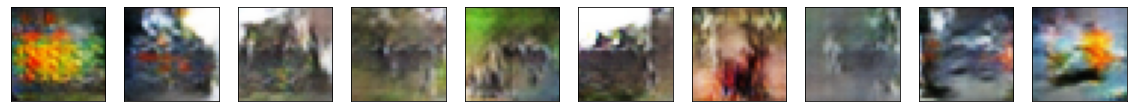

In [10]:
plot_images(generated_images)